In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#! pip install statsmodels --upgrade


In [2]:
train_data=pd.read_csv('C://Users//Administrator//Desktop//LTV//train_BRCpofr.csv')
test_data=pd.read_csv('C://Users//Administrator//Desktop//LTV//test_koRSKBP.csv')

In [3]:
train_data.head(3)

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212


결측값 확인

In [4]:
print(train_data.isnull().sum())

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64


In [5]:
print(test_data.isnull().sum())

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
dtype: int64


통계량 확인

In [6]:
train_data.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.000000,89392.000000,89392.000000,89392.000000,89392.000000
mean,44696.500000,0.575488,4.595669,4351.502416,97952.828978
std,25805.391969,0.494272,2.290446,3262.359775,90613.814793
min,1.000000,0.000000,0.000000,0.000000,24828.000000
25%,22348.750000,0.000000,3.000000,2406.000000,52836.000000
50%,44696.500000,1.000000,5.000000,4089.000000,66396.000000
75%,67044.250000,1.000000,6.000000,6094.000000,103440.000000
max,89392.000000,1.000000,8.000000,31894.000000,724068.000000


In [7]:
#왜도,첨도 확인
print(train_data.skew())


id                0.000000
marital_status   -0.305457
vintage          -0.378267
claim_amount      1.044233
cltv              2.753065
dtype: float64


cltv가 오른쪽에 데이터가 많이 몰린 모습이다.

In [8]:
print(train_data.kurtosis())

id               -1.200000
marital_status   -1.906738
vintage          -0.937270
claim_amount      3.231535
cltv              8.333803
dtype: float64


claim_amount, cltv는 이상치값이 많다.

1.claim_amount 전처리

In [9]:
train_data['claim_amount'].value_counts()

0        17671
4006        38
3912        33
3833        32
3834        32
         ...  
7135         1
11161        1
15195        1
8984         1
10086        1
Name: claim_amount, Length: 10889, dtype: int64

0이 17671개나 존재한다

array([[<AxesSubplot:title={'center':'claim_amount'}>]], dtype=object)

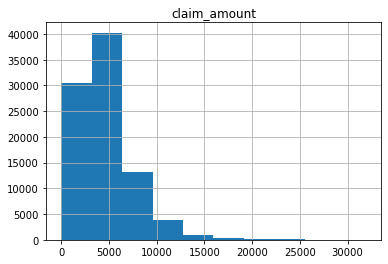

In [10]:
train_data.hist(column='claim_amount')

In [11]:
print(len(train_data[train_data['claim_amount']==0]))
print(len(train_data[train_data['claim_amount']>=10500]))

17671
3699


array([[<AxesSubplot:title={'center':'claim_amount'}>]], dtype=object)

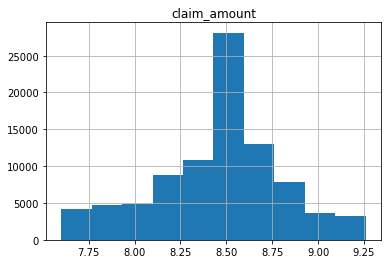

In [12]:
train_data['claim_amount']=train_data['claim_amount'].drop(train_data[(train_data['claim_amount']>=10500)|(train_data['claim_amount']==0)].index)
train_data['claim_amount']=train_data['claim_amount'].fillna(train_data['claim_amount'].mean())
train_data['claim_amount']=np.log(train_data['claim_amount'])
train_data.hist(column='claim_amount')

2.cltv 전처리

<AxesSubplot:>

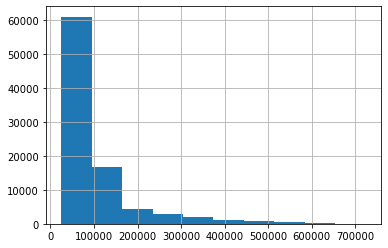

In [13]:
train_data['cltv'].hist()

In [14]:
len(train_data[(train_data['cltv']<=31000)])

2892

In [15]:
train_data['cltv']=train_data['cltv'].drop(train_data[(train_data['cltv']>=200000)|(train_data['cltv']<=31000)].index)
train_data['cltv']=train_data['cltv'].fillna(train_data['cltv'].mean())
train_data['cltv']=np.log(train_data['cltv'])

<AxesSubplot:>

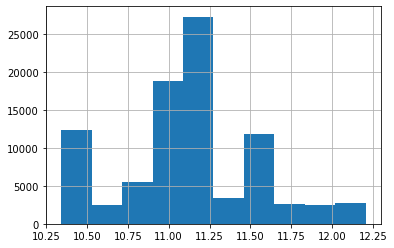

In [16]:
train_data['cltv'].hist()

범주형 변수 확인

In [17]:
train_data['gender'].value_counts()

Male      50497
Female    38895
Name: gender, dtype: int64

In [18]:
train_data['area'].value_counts()

Urban    62455
Rural    26937
Name: area, dtype: int64

In [19]:
train_data['qualification'].value_counts()

High School    46247
Bachelor       39399
Others          3746
Name: qualification, dtype: int64

In [20]:
train_data['income'].value_counts()

5L-10L           52716
2L-5L            21158
More than 10L    13664
<=2L              1854
Name: income, dtype: int64

In [21]:
train_data['num_policies'].value_counts()

More than 1    60263
1              29129
Name: num_policies, dtype: int64

In [22]:
train_data['type_of_policy'].value_counts()

Platinum    47796
Silver      21010
Gold        20586
Name: type_of_policy, dtype: int64

In [23]:
train_data['policy'].value_counts()

A    56644
B    24635
C     8113
Name: policy, dtype: int64

범주형 변수를 수치형 변수로 인코딩

In [24]:
le=LabelEncoder()
cat_train=train_data[['gender','area','qualification','income','num_policies','policy','type_of_policy']]
cat_test=train_data[['gender','area','qualification','income','num_policies','policy','type_of_policy']]
num_train=train_data[['id','marital_status','vintage','claim_amount','cltv']]
num_test=test_data[['id','marital_status','vintage','claim_amount']]

for i in cat_train:
    cat_train[i]=le.fit_transform(cat_train[i])
    
    
for i in cat_test:
    cat_test[i]=le.fit_transform(cat_test[i])
    
train=pd.concat([cat_train,num_train],axis=1)
test=pd.concat([cat_test,num_test],axis=1)



<ipython-input-24-ab136dc21dc0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_train[i]=le.fit_transform(cat_train[i])
<ipython-input-24-ab136dc21dc0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_train[i]=le.fit_transform(cat_train[i])
<ipython-input-24-ab136dc21dc0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

상관관계 확인

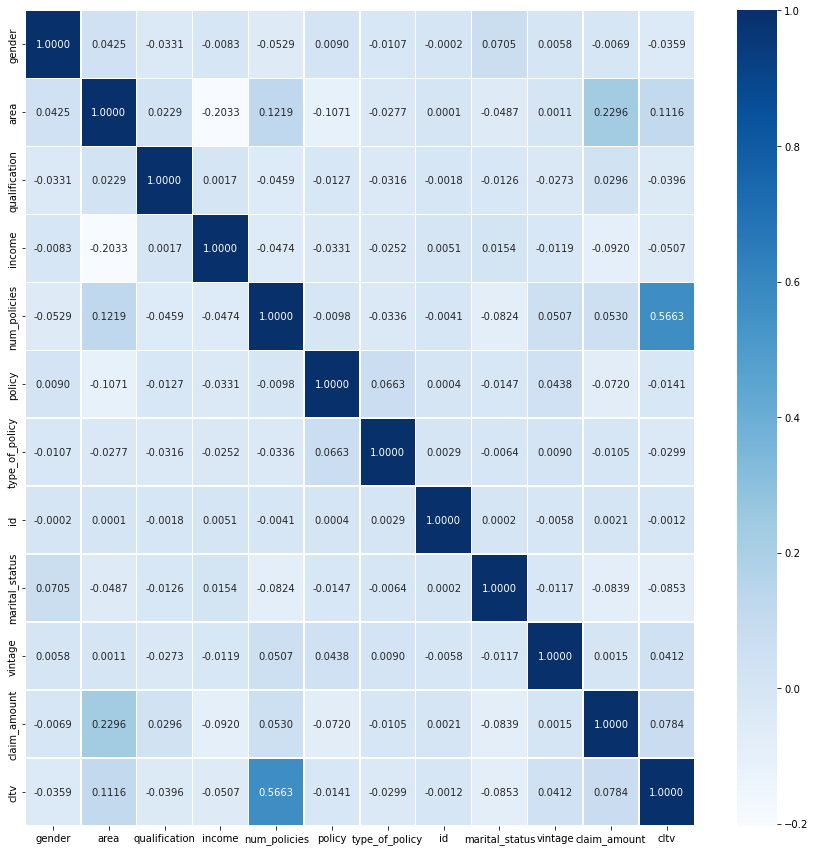

In [25]:
plt.figure(figsize=(15,15))
corr=sns.heatmap(train.corr(), annot=True, fmt = '.4f', linewidths=.4, cmap='Blues')
fig = corr.get_figure()

In [225]:
fig.savefig('C://Users//Administrator//Desktop//LTV//corr.png')


상관관계가 매우 낮아 설명력이 낮다고 판단되는 gender ,vintage, qualification, policy,id 변수는 삭제

In [26]:
y_train=train[['cltv']]
X_train=train.drop(columns=['cltv','gender','vintage','qualification','policy','id'])

In [27]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train)

In [28]:
X_train.head(3)

,area,income,num_policies,type_of_policy,marital_status,claim_amount
62753,1,1,1,1,0,9.115150
44211,0,0,0,0,1,8.730690
2559,0,0,1,0,0,7.774436


In [29]:
minmax_scaler=MinMaxScaler()
X_scaled_train=minmax_scaler.fit_transform(X_train)
X_scaled_val=minmax_scaler.fit_transform(X_val)

회귀분석 수행

In [31]:
model1=sm.OLS(y_train,X_scaled_train)
fitted_model1 = model1.fit()
print(fitted_model1.summary())

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model1.exog, i)} 
             for i, column in enumerate(model1.exog_names)
             if column != 'Intercept')  

                                 OLS Regression Results                                
Dep. Variable:                   cltv   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                          1.897e+05
Date:                Tue, 28 Feb 2023   Prob (F-statistic):                        0.00
Time:                        16:05:35   Log-Likelihood:                     -1.5983e+05
No. Observations:               67044   AIC:                                  3.197e+05
Df Residuals:                   67038   BIC:                                  3.197e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,컬럼,VIF
0,x1,3.360992
1,x2,2.072930
2,x3,2.783536
3,x4,2.685862
4,x5,2.069616
5,x6,5.164802


Adj. R-squared가 1에 매우 가까워 설명력이 높고 p-value가 0.05이하이므로 통계적으로 유의하다고 판단된다.
분산팽창요인(VIF)을 살펴보았을때 모든 변수에서 10이하의 값을 가지므로 다중공산성에도 문제가 없다고 판단하였다.

# 모델 적합 (XGBoost)

In [32]:
xgb1 = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
xgb1.fit(X_scaled_train,y_train)

preds_val_xgb = xgb1.predict(X_scaled_val)
mae_1 = mean_absolute_error(y_val, preds_val_xgb)
print(mae_1)

0.2838648506069462


learning_rate값 조정 (0.1 -> 0.01 )

In [33]:
xgb2 = XGBRegressor(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
xgb2.fit(X_scaled_train,y_train)

preds_val_xgb2 = xgb2.predict(X_scaled_val)
mae_2 = mean_absolute_error(y_val, preds_val_xgb2)
print(mae_2)

0.27859278623514877


learning_rate값 조정 (0.01 -> 0.15 )

In [34]:
xgb3 = XGBRegressor(
    learning_rate =0.15,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
xgb3.fit(X_scaled_train,y_train)

preds_val_xgb3 = xgb3.predict(X_scaled_val)
mae_3 = mean_absolute_error(y_val, preds_val_xgb3)
print(mae_3)

0.28804820336989884


max_depth , min_child_weight 조정

In [35]:
xgb4 = XGBRegressor(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=7,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
xgb4.fit(X_scaled_train,y_train)

preds_val_xgb4 = xgb4.predict(X_scaled_val)
mae_4 = mean_absolute_error(y_val, preds_val_xgb4)
print("mae: %.6f" %mae_4)

mae: 0.278570
